In [1]:
using LinearAlgebra, Random, Distributions, NLsolve, CairoMakie, Statistics

First, let us create a NamedTuple with our parameters.

In [39]:
params = (; β = 0.72, # bargaining_power
            r = 0.012, # discount rate
            λ = 4, # arrival rate
            z = 0.4, # value of leisure
            p_star = 1., # productivity
            s_star = 0.1, # separation rate
            c = 0.213, # cost of vacancy
            σ = 0.0165, # standard deviation 
            γ = 0.004, # autoregressive coefficient
            n = 2001, # gridpoints
            lb = -1., # bounds for grid
            ub = 1., # bounds for grid
            μ = 1.355, # constant term in matching function
            me = -0.72, # exponent in matching function
            max_iter  = 1000, # maximum number of iterations
            agents = 10000, # number of agents
            periods = 1213, # number of periods
            seed1 = 7, # seed1 for random number generator
            seed2 = 9, # seed2 for random number generator
            seed3 = 11 ) # seed3 for random number generator 

(β = 0.72, r = 0.012, λ = 4, z = 0.4, p_star = 1.0, s_star = 0.1, c = 0.213, σ = 0.0165, γ = 0.004, n = 2001, lb = -1.0, ub = 1.0, μ = 1.355, me = -0.72, max_iter = 1000, agents = 10000, periods = 1213, seed1 = 7, seed2 = 9, seed3 = 11)

In [37]:
function matching_function(grid, params)
    (; μ, me) = params
    return μ .* (grid .^ me)
end

matching_function (generic function with 1 method)

In [38]:
function generate_income_process(params)
    (; n, lb, ub) = params
    Δ = ub / n
    grid = LinRange(lb, ub, n)
    exp_grid = exp.(grid)
    transition_matrix = zeros(n, n)
    for i in 1:n
        if i == 1
            transition_matrix[i, i] = ( 1/2 ) * (1 .+ (grid[i] / (n*Δ)))
            transition_matrix[i, i+1] = ( 1/2 ) * (1 .- (grid[i] / (n*Δ)))
        elseif i == n
            transition_matrix[i, i-1] = ( 1/2 ) * (1 .+ (grid[i] / (n*Δ)))
            transition_matrix[i, i] = ( 1/2 ) * (1 .- (grid[i] / (n*Δ)))
        else
            transition_matrix[i, i-1] = ( 1/2 ) * (1 .+ (grid[i] / (n*Δ)))
            transition_matrix[i, i+1] = ( 1/2 ) * (1 .- (grid[i] / (n*Δ)))
        end
    end
    return exp_grid, transition_matrix
end

income_process, transition_matrix = generate_income_process(params)

([0.36787944117144233, 0.3682475046136629, 0.3686159363034188, 0.3689847366091417, 0.369353905899632, 0.3697234445440589, 0.3700933529119613, 0.37046363137324734, 0.37083428029819565, 0.37120530005745517  …  2.6939270528874992, 2.696622327353013, 2.6993202984410796, 2.7020209688496686, 2.7047243412794524, 2.7074304184338023, 2.7101392030187967, 2.7128506977432196, 2.715564905318567, 2.718281828459045], [0.0 1.0 … 0.0 0.0; 0.0004999999999999449 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0004999999999999449; 0.0 0.0 … 1.0 0.0])

In [5]:
function productivity_grid(params)
    (; z, p_star) = params
    grid = generate_income_process(params)
    p_grid = z .+ (grid[1] .* (p_star - z))
    return p_grid
end

function separation_grid(params)
    (; n, s_star) = params
    grid = generate_income_process(params)
    s_grid = grid[1] .* s_star
    return s_grid
end

function theta_grid(params)
    (; n) = params
    grid = generate_income_process(params)
    θ_grid = LinRange(0.1,3,n)
    return θ_grid
end

theta_grid (generic function with 1 method)

In [6]:
function generate_poisson_matrix(params)
    (;periods, agents, λ) = params
    dist = Poisson(λ)
    matrix = rand(dist, 1, periods)
    matrix[matrix .!= λ] .= 0.0
    matrix[matrix .!= 0.0] .= 1.0
    transition_matrix = zeros(1, periods)
    Random.seed!(params.seed2)
    dist2 = Uniform(0,1)
    transitions = rand(dist2, 1, periods)
    return matrix, transitions
end

arrival_matrix, transitions = generate_poisson_matrix(params)
display(arrival_matrix)

1×1213 Matrix{Int64}:
 0  0  1  0  0  0  0  1  0  0  1  0  1  …  0  0  0  0  0  0  1  0  0  1  0  0

In [7]:
function generate_sep_matrix(params)
    (;agents, periods, seed1) = params
    Random.seed!(seed1)
    dist = Uniform(0., 1.)
    matrix = rand(dist, agents, periods)
    matrix[matrix .> 0.1] .= 0.0
    matrix[matrix .!= 0.0] .= 1.0
    return matrix
end

sep_matrix = generate_sep_matrix(params)

10000×1213 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [8]:
function generate_matching_matrix(params)
    (;agents, periods, seed2) = params
    Random.seed!(seed2)
    dist = Uniform(0., 1.)
    matrix = rand(dist, agents, periods)
    return matrix
end

match_matrix = generate_matching_matrix(params)

10000×1213 Matrix{Float64}:
 0.242708    0.711406   0.826878   …  0.694117   0.606764   0.37149
 0.727472    0.16163    0.83012       0.443679   0.629028   0.887678
 0.904969    0.752876   0.85529       0.689347   0.340107   0.63682
 0.728999    0.132026   0.51149       0.703694   0.298712   0.119932
 0.0281668   0.707046   0.855064      0.187131   0.346438   0.743677
 0.294462    0.410857   0.234219   …  0.764188   0.491245   0.167247
 0.231121    0.246868   0.360231      0.498777   0.0795437  0.379268
 0.0741847   0.585746   0.668276      0.556771   0.270171   0.696627
 0.445605    0.73798    0.284414      0.227099   0.0467458  0.470247
 0.0851107   0.924341   0.0163822     0.0442784  0.908931   0.379077
 ⋮                                 ⋱  ⋮                     
 0.573564    0.924095   0.15549       0.185872   0.248375   0.641115
 0.00538528  0.135019   0.318873      0.331889   0.405052   0.447125
 0.0863734   0.221253   0.370045      0.358984   0.322925   0.739432
 0.424457    0.3

In [9]:
function optim_theta(grid, params)
    (; β, r, λ, z, p_star, s_star, c, σ, γ, n, lb, ub, μ, me, max_iter) = params
    Δ = ub / n
    exp_grid, transition_matrix = generate_income_process(params)
    prod_grid = productivity_grid(params)
    iter = 0
    error = Inf
    new_grid = zeros(n)
    while iter < max_iter && error > 0.001
        iter += 1
        match_grid = matching_function(grid, params)
        for i in 1:n
            if i == 1
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-z)) / c ) - β*theta[1] + λ*((transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            elseif i == n
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-z)) / c ) - β*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1])), [grid[i]])
                new_grid[i] = result.zero[1]
            else
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-z)) / c ) - β*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1]) + (transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            end
        end
        error = norm(new_grid - grid)
        grid = copy(new_grid)
        if iter % 1 == 0
            println("Iteration: $iter, Error: $error")
        end
    end
    find_probs = matching_function(grid, params).*grid
    find_probs = find_probs ./ maximum(find_probs)
    return grid, find_probs
end

θ_grid = theta_grid(params)
probs_find = optim_theta(θ_grid, params)[2]

Iteration: 1, Error: 22.24042821451652
Iteration: 2, Error: 1.645337822710512
Iteration: 3, Error: 0.13490677881814264
Iteration: 4, Error: 0.012028792790704025
Iteration: 5, Error: 0.0012228452433972544
Iteration: 6, Error: 0.00014429373642639175


2001-element Vector{Float64}:
 0.5625584887286226
 0.562721438395461
 0.562884415492137
 0.5630474623743051
 0.563210532922636
 0.5633736592481231
 0.563536832075869
 0.5637000371424581
 0.5638633060063852
 0.5640266064640209
 ⋮
 0.9977149343715417
 0.9980002871043534
 0.998285720187221
 0.9985712318225917
 0.9988568263599019
 0.9991424988143064
 0.9994282524091771
 0.9997140871828105
 1.0

In [10]:
function initial_u(params)
    (; agents, seed1) = params
    Random.seed!(seed1)
    u_init = randn(1)
    dist = Uniform(0., 1.)
    matrix = rand(dist, agents)
    matrix[matrix .> u_init] .= 1
    matrix[matrix .!= 1] .= 0
    return matrix
end

u_init = initial_u(params)

10000-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [11]:
function simulation(params)
    (; agents, periods, n) = params

    p_grid = productivity_grid(params)
    s_grid = separation_grid(params)
    
    p_init = p_grid[10]
    
    agg_prod, agg_transitions = generate_poisson_matrix(params)
    income_process, transitions = generate_income_process(params)
    
    index = findfirst(isequal(p_init), p_grid)
    
    initial_θ = θ_grid[index]
    
    employment_sim = zeros(agents , periods) 
    employment_sim[:,1] .= u_init .== 0.0
    
    sim_p = zeros(1, periods)
    sim_p[:,1] .= p_init
    
    sim_θ = zeros(1, periods)
    sim_θ[:,1] .= initial_θ
    
    sim_f = zeros(1, periods) # θ*q(θ)
    sim_f[:,1] .= sim_θ[:,1] .* matching_function(sim_θ[:,1], params)
    
    sim_u = zeros(1, periods)
    fraction = mean(u_init .== 1.0)
    sim_u[:,1] .= fraction
    
    sim_v = zeros(1, periods)
    sim_v[:,1] .= sim_u[:,1] .* sim_θ[:,1] 
    
    thetas, probs_find = optim_theta(θ_grid, params)
    match_matrix = generate_matching_matrix(params)
    sep_matrix = generate_sep_matrix(params)
    
    for i in 1:agents
        for j in 1:periods
            index = findfirst(isequal(sim_p[1,j]), p_grid)
            if agg_prod[1,j] == 1.0
                if agg_transitions[1,j] <= transitions[index,index-1]
                    if index == 1
                        sim_p[1,j] = p_grid[index]
                        sim_p[1,j+1] = p_grid[index]
                        sim_θ[1,j] = thetas[index]
                        sim_θ[1,j+1] = thetas[index]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params))
                        sim_f[1,j+1] = sim_f[1,j]                  
                    else
                        sim_p[1,j] = p_grid[index-1]
                        sim_θ[1,j] = thetas[index-1]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params))
                        sim_p[1,j+1] = p_grid[index-1]
                        sim_θ[1,j+1] = thetas[index-1]
                        sim_f[1,j+1] = sim_f[1,j]  
                    end
                elseif index < n
                    index2 = index + 1
                    sim_p[1,j+1] = p_grid[index2]
                    sim_θ[1,j+1] = thetas[index2]
                    sim_f[1,j+1] = sim_f[1,j]
                elseif index == n
                    sim_p[1,j+1] = p_grid[index]
                    sim_θ[1,j+1] = thetas[index]
                    sim_f[1,j+1] = sim_f[1,j]
                end
            elseif j < periods 
                sim_p[1,j+1] = sim_p[1,j]
                sim_θ[1,j+1] = sim_θ[1,j]
                sim_f[1,j+1] = sim_f[1,j]   
            end
            if employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 0.0 && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 1.0 && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if employment_sim[i,j] == 0.0 && match_matrix[i,j] <= probs_find[index] && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 0.0 && match_matrix[i,j] > probs_find[index] && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if i == 1 && j == 1213
                println("completed agent $i")
            end
            if i % 1000 == 0 && j == 1213
                println("completed agent $i")
            end
        end
        #if j < periods
         #   sim_u[1,j+1] = 1 - mean(employment_sim[:,j+1])
          #  sim_v[1,j+1] = sim_u[1,j+1] .* sim_θ[1,j+1]
        #end
    end
    for j in 1:periods
        sim_u[1,j] = 1 - mean(employment_sim[:,j])
        sim_v[1,j] = sim_u[1,j] .* sim_θ[1,j]
    end
    return sim_u, sim_v, sim_p, sim_θ, sim_f, employment_sim
end

sim_u, sim_v, sim_p, sim_θ, sim_f, employment_sim = simulation(params)

Iteration: 1, Error: 22.24042821451652
Iteration: 2, Error: 1.645337822710512
Iteration: 3, Error: 0.13490677881814264
Iteration: 4, Error: 0.012028792790704025
Iteration: 5, Error: 0.0012228452433972544
Iteration: 6, Error: 0.00014429373642639175
completed agent 1
completed agent 1000
completed agent 2000
completed agent 3000
completed agent 4000
completed agent 5000
completed agent 6000
completed agent 7000
completed agent 8000
completed agent 9000
completed agent 10000


([1.0 0.4387 … 0.139 0.14059999999999995], [0.11305000000000001 0.049595035 … 0.06121253945440874 0.06198110348082969], [0.6227231800344731 0.6227231800344731 … 0.6753187879575727 0.6755942444508223], [0.11305000000000001 0.11305000000000001 … 0.4403779816863938 0.44083288393193254], [0.7359614288056299 0.7359614288056299 … 1.0723267193797845 1.0723267193797845], [0.0 1.0 … 1.0 1.0; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 1.0 1.0; 0.0 1.0 … 0.0 1.0])

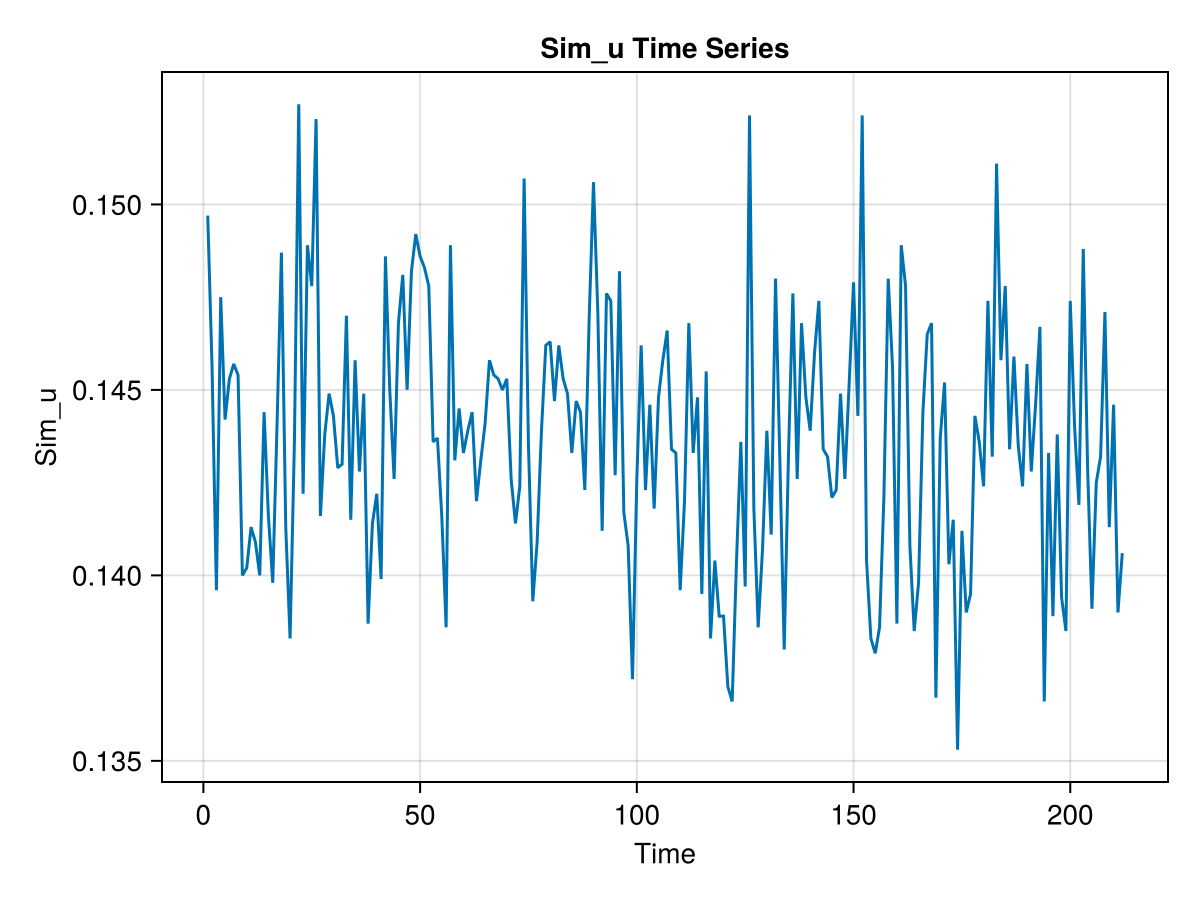

In [12]:
# Select the last 212 periods of each series
sim_u_last_212 = sim_u[end-211:end]
sim_v_last_212 = sim_v[end-211:end]
sim_p_last_212 = sim_p[end-211:end]
sim_θ_last_212 = sim_θ[end-211:end]
sim_f_last_212 = sim_f[end-211:end]

# Create a range of x-values
x = range(1, stop=212, length=length(sim_u_last_212))

# Plot sim_u
fig_u = Figure()
ax_u = Axis(fig_u[1, 1], title = "Sim_u Time Series", xlabel = "Time", ylabel = "Sim_u")
lines!(ax_u, x, sim_u_last_212)
fig_u

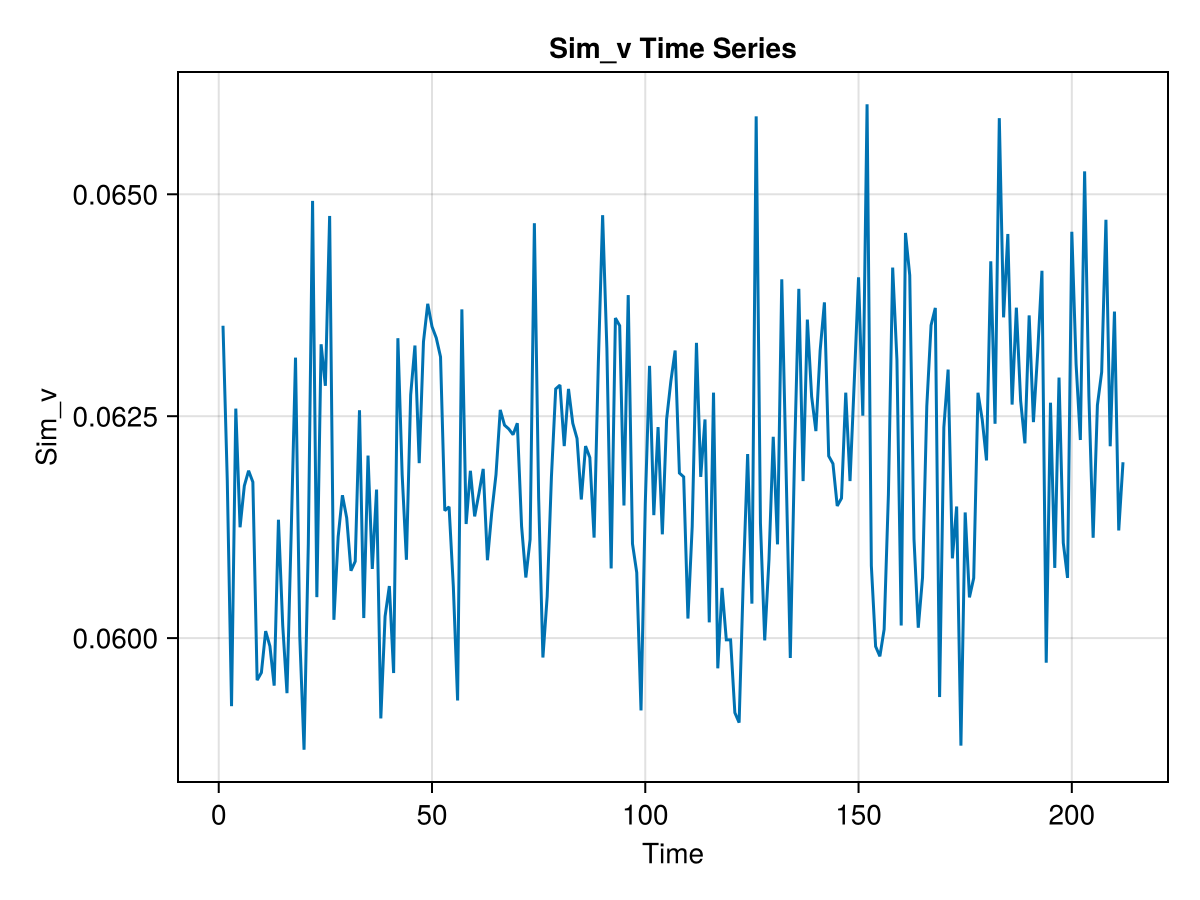

In [13]:
# Plot sim_v
fig_v = Figure()
ax_v = Axis(fig_v[1, 1], title = "Sim_v Time Series", xlabel = "Time", ylabel = "Sim_v")
lines!(ax_v, x, sim_v_last_212)
fig_v

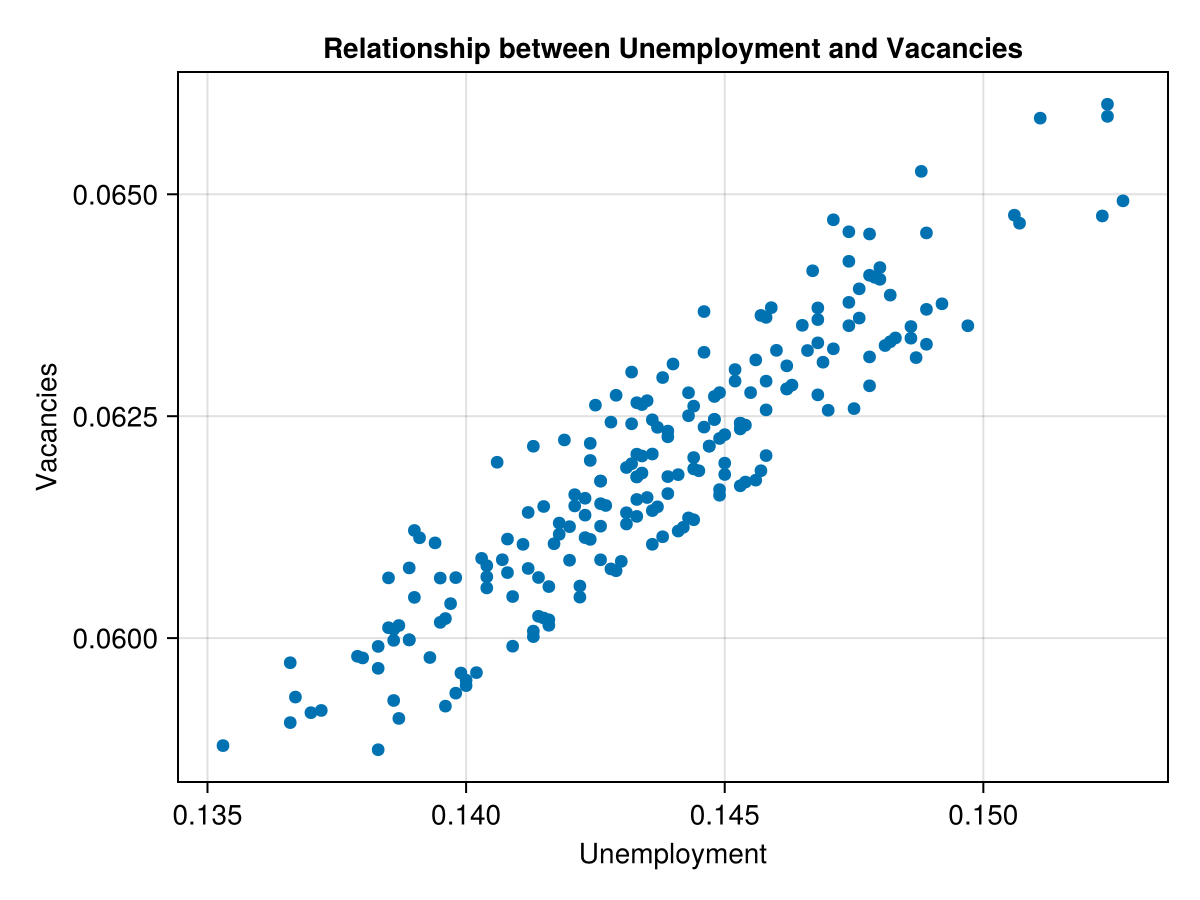

In [69]:
# Convert sim_u and sim_v to 1D arrays
sim_u_1d = vec(sim_u_last_212)
sim_v_1d = vec(sim_v_last_212)

# Create a scatter plot of sim_u_1d and sim_v_1d
fig = Figure()
ax = Axis(fig[1, 1], title = "Relationship between Unemployment and Vacancies", xlabel = "Unemployment", ylabel = "Vacancies")
scatter!(ax, sim_u_1d, sim_v_1d)
fig

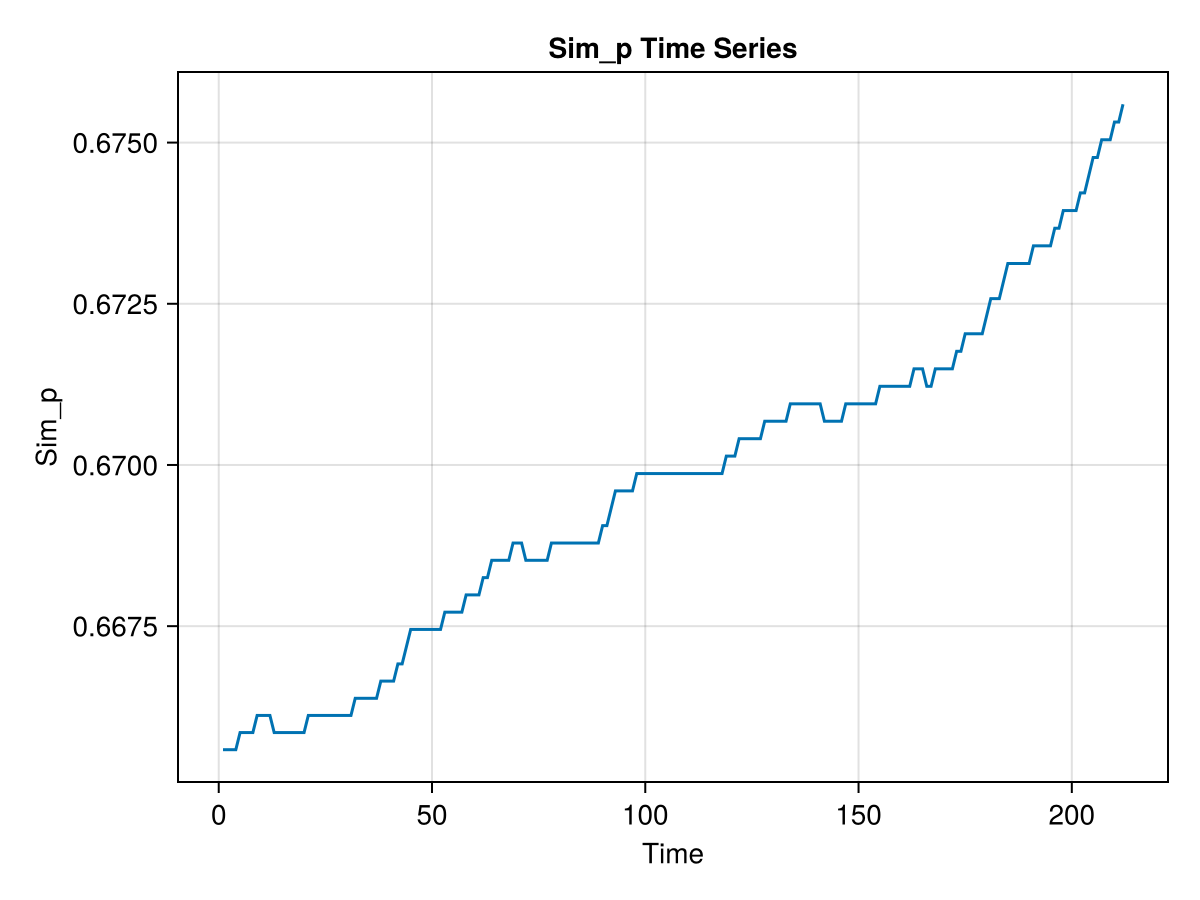

CairoMakie.Screen{IMAGE}


In [33]:
fig_p = Figure()
ax_p = Axis(fig_p[1, 1], title = "Sim_p Time Series", xlabel = "Time", ylabel = "Sim_p")
lines!(ax_p, x, sim_p_last_212)

# Display the plot
display(fig_p)

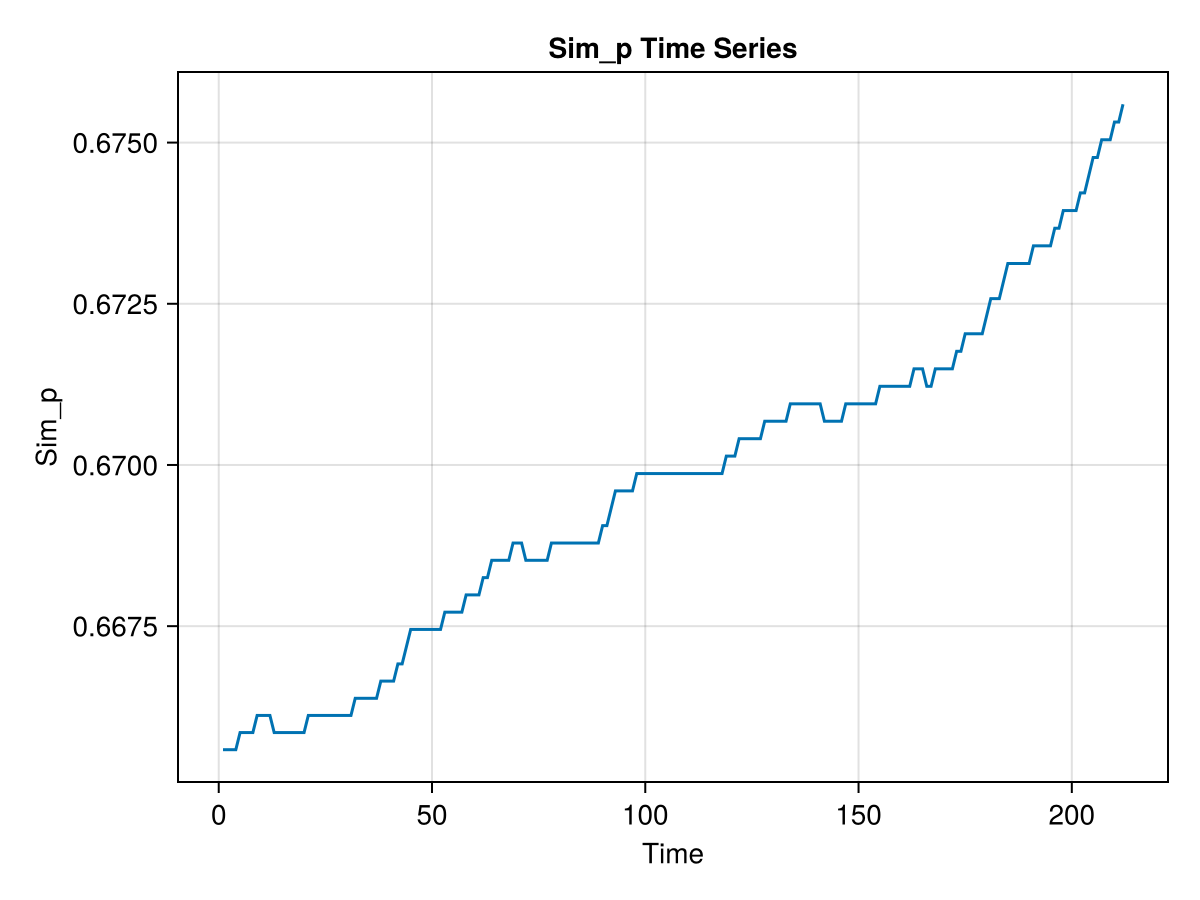

In [14]:
# Plot sim_p
fig_p = Figure()
ax_p = Axis(fig_p[1, 1], title = "Sim_p Time Series", xlabel = "Time", ylabel = "Sim_p")
lines!(ax_p, x, sim_p_last_212)
fig_p

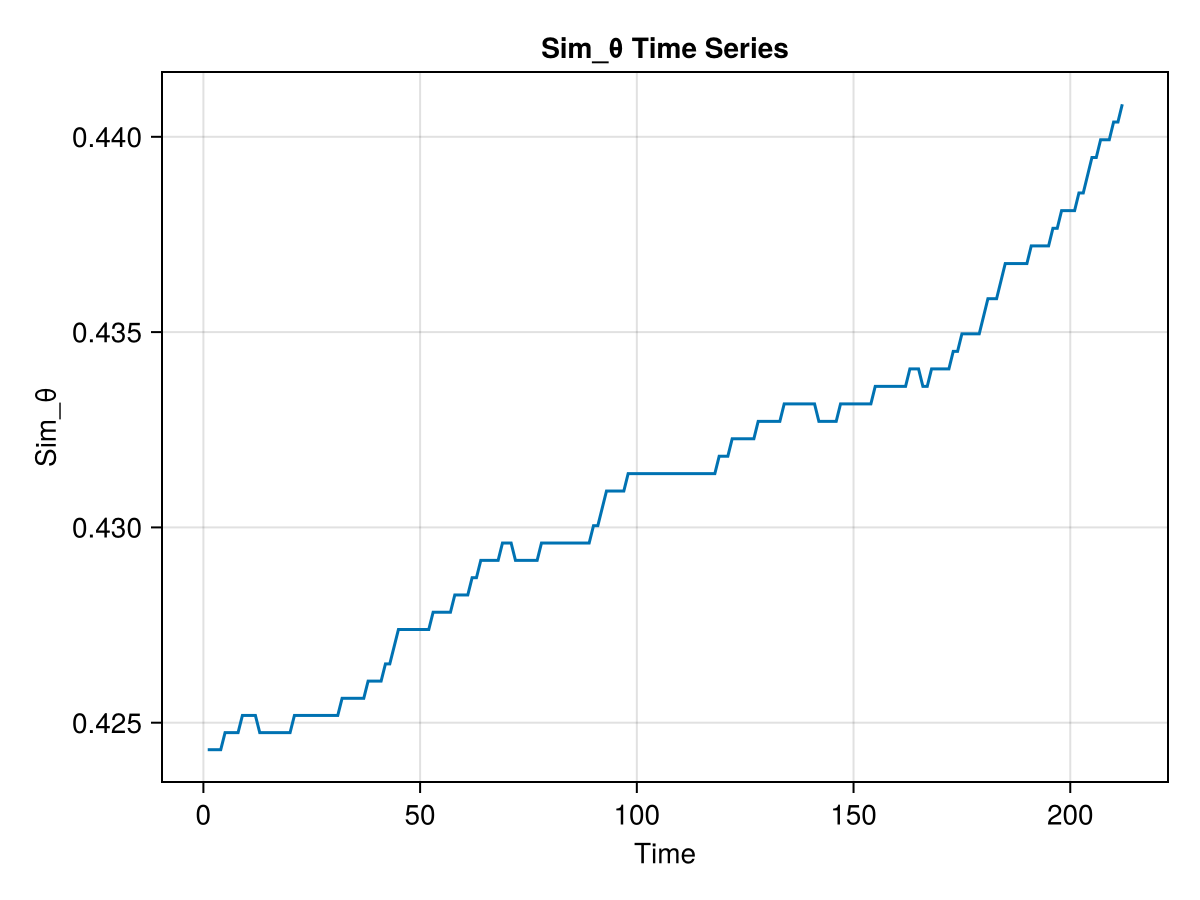

In [15]:
# Plot sim_θ
fig_θ = Figure()
ax_θ = Axis(fig_θ[1, 1], title = "Sim_θ Time Series", xlabel = "Time", ylabel = "Sim_θ")
lines!(ax_θ, x, sim_θ_last_212)
fig_θ

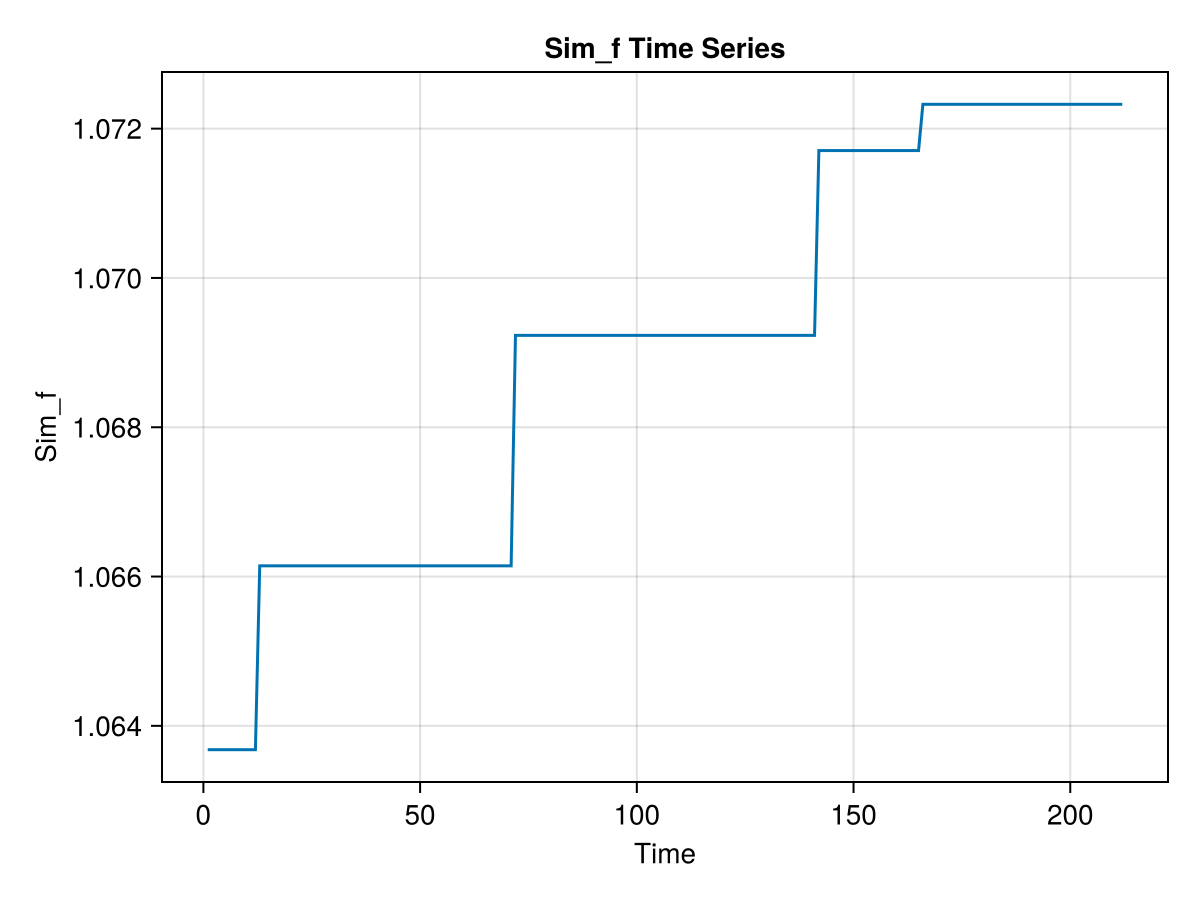

In [16]:
# Plot sim_f
fig_f = Figure()
ax_f = Axis(fig_f[1, 1], title = "Sim_f Time Series", xlabel = "Time", ylabel = "Sim_f")
lines!(ax_f, x, sim_f_last_212)
fig_f

In [17]:
function bargaining_grid(params)
    (; n) = params
    lower_bound = 0.64
    upper_bound = 0.80
    grid = LinRange(lower_bound, upper_bound, n)    
    return reverse(grid)
end

function optim_theta_β(grid, params)
    (; r, λ, z, p_star, s_star, c, σ, γ, n, lb, ub, μ, me, max_iter) = params
    Δ = ub / n
    exp_grid, transition_matrix = generate_income_process(params)
    prod_grid = productivity_grid(params)
    β = bargaining_grid(params)
    iter = 0
    error = Inf
    new_grid = zeros(n)
    while iter < max_iter && error > 0.001
        iter += 1
        match_grid = matching_function(grid, params)
        for i in 1:n
            if i == 1
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β[i])*(prod_grid[i]-z)) / c ) - β[i]*theta[1] + λ*((transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            elseif i == n
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β[i])*(prod_grid[i]-z)) / c ) - β[i]*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1])), [grid[i]])
                new_grid[i] = result.zero[1]
            else
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β[i])*(prod_grid[i]-z)) / c ) - β[i]*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1]) + (transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            end
        end
        error = norm(new_grid - grid)
        grid = copy(new_grid)
        if iter % 1 == 0
            println("Iteration: $iter, Error: $error")
        end
    end
    find_probs = matching_function(grid, params).*grid
    find_probs = find_probs ./ maximum(find_probs)
    return grid, find_probs
end

θ_grid = theta_grid(params)
probs_find = optim_theta_β(θ_grid, params)[2]

Iteration: 1, Error: 20.095365965672737
Iteration: 2, Error: 1.5756105466694514
Iteration: 3, Error: 0.13157801754922868
Iteration: 4, Error: 0.01142946280340591
Iteration: 5, Error: 0.0010867025345807162
Iteration: 6, Error: 0.00012097652090862869


2001-element Vector{Float64}:
 0.4484468728528742
 0.44863997428173585
 0.44883312217041765
 0.44902634086050675
 0.44921961781604475
 0.44941295598059405
 0.44960635382213515
 0.44979981754043474
 0.4499933383438468
 0.4501869229471494
 ⋮
 0.9969445929268261
 0.9973260449010702
 0.9977076349061118
 0.9980893590283808
 0.9984712164748547
 0.9988532116967381
 0.9992353380298319
 0.9996176051678262
 1.0

In [24]:
function simulation_β(params)
    (; agents, periods, n) = params
    
    p_grid = productivity_grid(params)
    s_grid = separation_grid(params)
    
    p_init = p_grid[10]
    
    agg_prod, agg_transitions = generate_poisson_matrix(params)
    income_process, transitions = generate_income_process(params)
    
    index = findfirst(isequal(p_init), p_grid)
    
    initial_θ = θ_grid[index]
    
    employment_sim = zeros(agents , periods) 
    employment_sim[:,1] .= u_init .== 0.0
    
    sim_p = zeros(1, periods)
    sim_p[:,1] .= p_init
    
    sim_θ = zeros(1, periods)
    sim_θ[:,1] .= initial_θ
    
    sim_f = zeros(1, periods) # θ*q(θ)
    sim_f[:,1] .= sim_θ[:,1] .* matching_function(sim_θ[:,1], params)
    
    sim_u = zeros(1, periods)
    fraction = mean(u_init .== 1.0)
    sim_u[:,1] .= fraction
    
    sim_v = zeros(1, periods)
    sim_v[:,1] .= sim_u[:,1] .* sim_θ[:,1] 
    
    thetas, probs_find = optim_theta_β(θ_grid, params)
    match_matrix = generate_matching_matrix(params)
    sep_matrix = generate_sep_matrix(params)
    
    for i in 1:agents
        for j in 1:periods
            index = findfirst(isequal(sim_p[1,j]), p_grid)
            if agg_prod[1,j] == 1.0
                if agg_transitions[1,j] <= transitions[index,index-1]
                    if index == 1
                        sim_p[1,j] = p_grid[index]
                        sim_p[1,j+1] = p_grid[index]
                        sim_θ[1,j] = thetas[index]
                        sim_θ[1,j+1] = thetas[index]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params))
                        sim_f[1,j+1] = sim_f[1,j]                  
                    else
                        sim_p[1,j] = p_grid[index-1]
                        sim_θ[1,j] = thetas[index-1]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params))
                        sim_p[1,j+1] = p_grid[index-1]
                        sim_θ[1,j+1] = thetas[index-1]
                        sim_f[1,j+1] = sim_f[1,j]  
                    end
                elseif index < n
                    index2 = index + 1
                    sim_p[1,j+1] = p_grid[index2]
                    sim_θ[1,j+1] = thetas[index2]
                    sim_f[1,j+1] = sim_f[1,j]
                elseif index == n
                    sim_p[1,j+1] = p_grid[index]
                    sim_θ[1,j+1] = thetas[index]
                    sim_f[1,j+1] = sim_f[1,j]
                end
            elseif j < periods 
                sim_p[1,j+1] = sim_p[1,j]
                sim_θ[1,j+1] = sim_θ[1,j]
                sim_f[1,j+1] = sim_f[1,j]   
            end
            if employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 0.0 && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 1.0 && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if employment_sim[i,j] == 0.0 && match_matrix[i,j] <= probs_find[index] && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 0.0 && match_matrix[i,j] > probs_find[index] && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if i == 1 && j == 1213
                println("completed agent $i")
            end
            if i % 1000 == 0 && j == 1213
                println("completed agent $i")
            end
        end
    end
    for j in 1:periods
        sim_u[1,j] = 1 - mean(employment_sim[:,j])
        sim_v[1,j] = sim_u[1,j] .* sim_θ[1,j]
    end
    return sim_u, sim_v, sim_p, sim_θ, sim_f
end

β_sim_u, β_sim_v, β_sim_p, β_sim_θ, β_sim_f = simulation_β(params)

Iteration: 1, Error: 20.095365965672737
Iteration: 2, Error: 1.5756105466694514
Iteration: 3, Error: 0.13157801754922868
Iteration: 4, Error: 0.01142946280340591
Iteration: 5, Error: 0.0010867025345807162
Iteration: 6, Error: 0.00012097652090862869
completed agent 1
completed agent 1000
completed agent 2000
completed agent 3000
completed agent 4000
completed agent 5000
completed agent 6000
completed agent 7000
completed agent 8000
completed agent 9000
completed agent 10000


([1.0 0.5535 … 0.16449999999999998 0.1614], [0.11305000000000001 0.06257317500000001 … 0.051825463780261385 0.050925347335062404], [0.6227231800344731 0.6227231800344731 … 0.6753187879575727 0.6755942444508223], [0.11305000000000001 0.11305000000000001 … 0.31504841203806316 0.3155225981106717], [0.7359614288056299 0.7359614288056299 … 0.9744053077878686 0.9744053077878686])

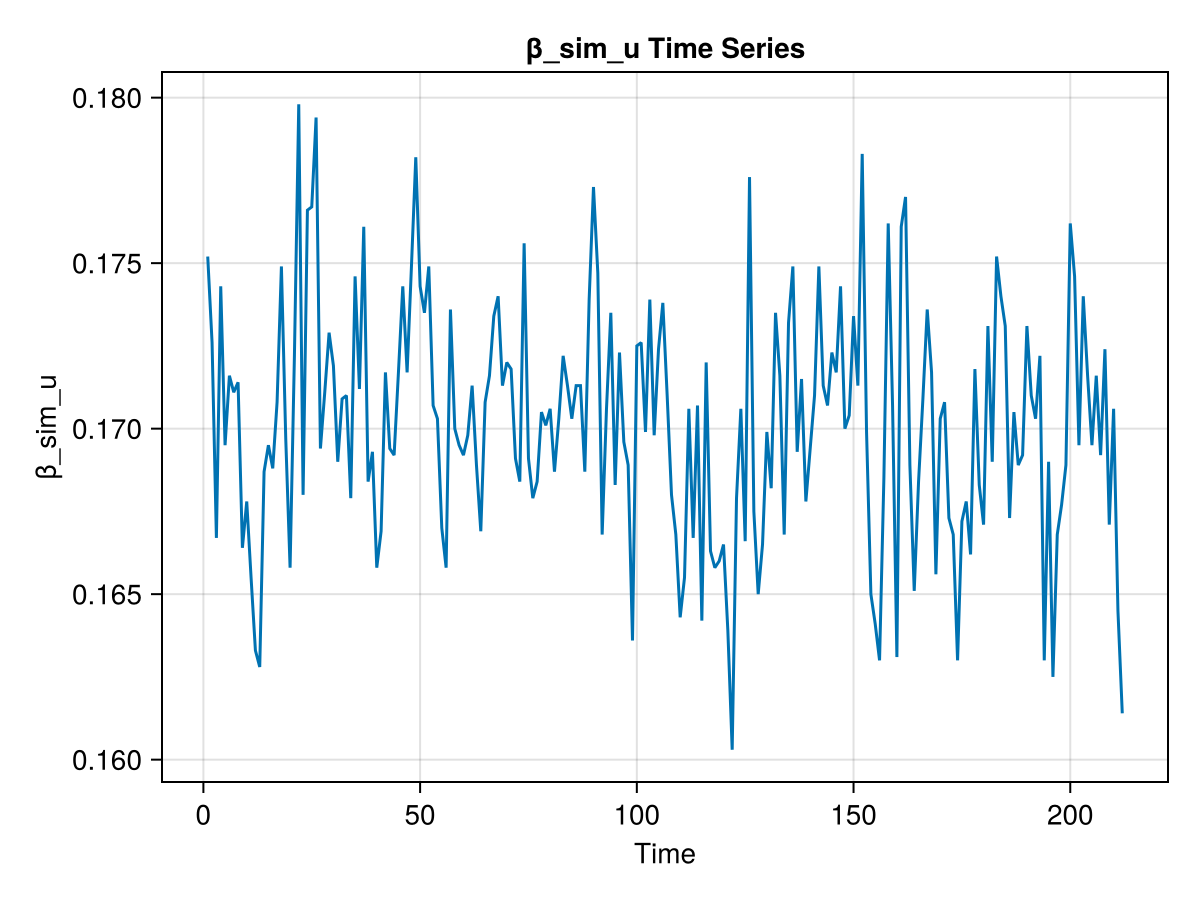

In [25]:
# Select the last 212 periods of each series
β_sim_u_last_212 = β_sim_u[end-211:end]
β_sim_v_last_212 = β_sim_v[end-211:end]
β_sim_p_last_212 = β_sim_p[end-211:end]
β_sim_θ_last_212 = β_sim_θ[end-211:end]
β_sim_f_last_212 = β_sim_f[end-211:end]

# Create a range of x-values
x = range(1, stop=212, length=length(β_sim_u_last_212))

# Plot β_sim_u
fig_β_sim_u = Figure()
ax_β_sim_u = Axis(fig_β_sim_u[1, 1], title = "β_sim_u Time Series", xlabel = "Time", ylabel = "β_sim_u")
lines!(ax_β_sim_u, x, β_sim_u_last_212)
fig_β_sim_u

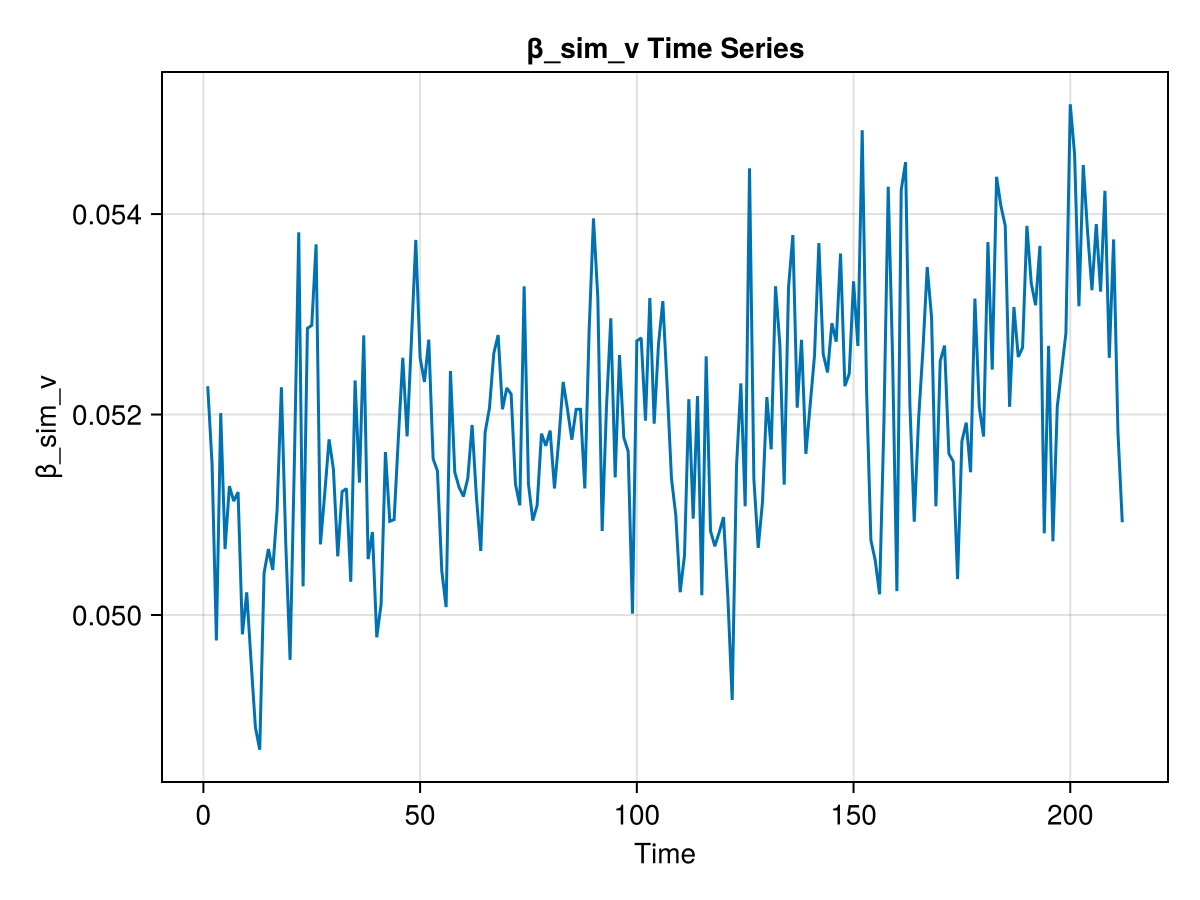

In [26]:
# Plot β_sim_v
fig_β_sim_v = Figure()
ax_β_sim_v = Axis(fig_β_sim_v[1, 1], title = "β_sim_v Time Series", xlabel = "Time", ylabel = "β_sim_v")
lines!(ax_β_sim_v, x, β_sim_v_last_212)
fig_β_sim_v

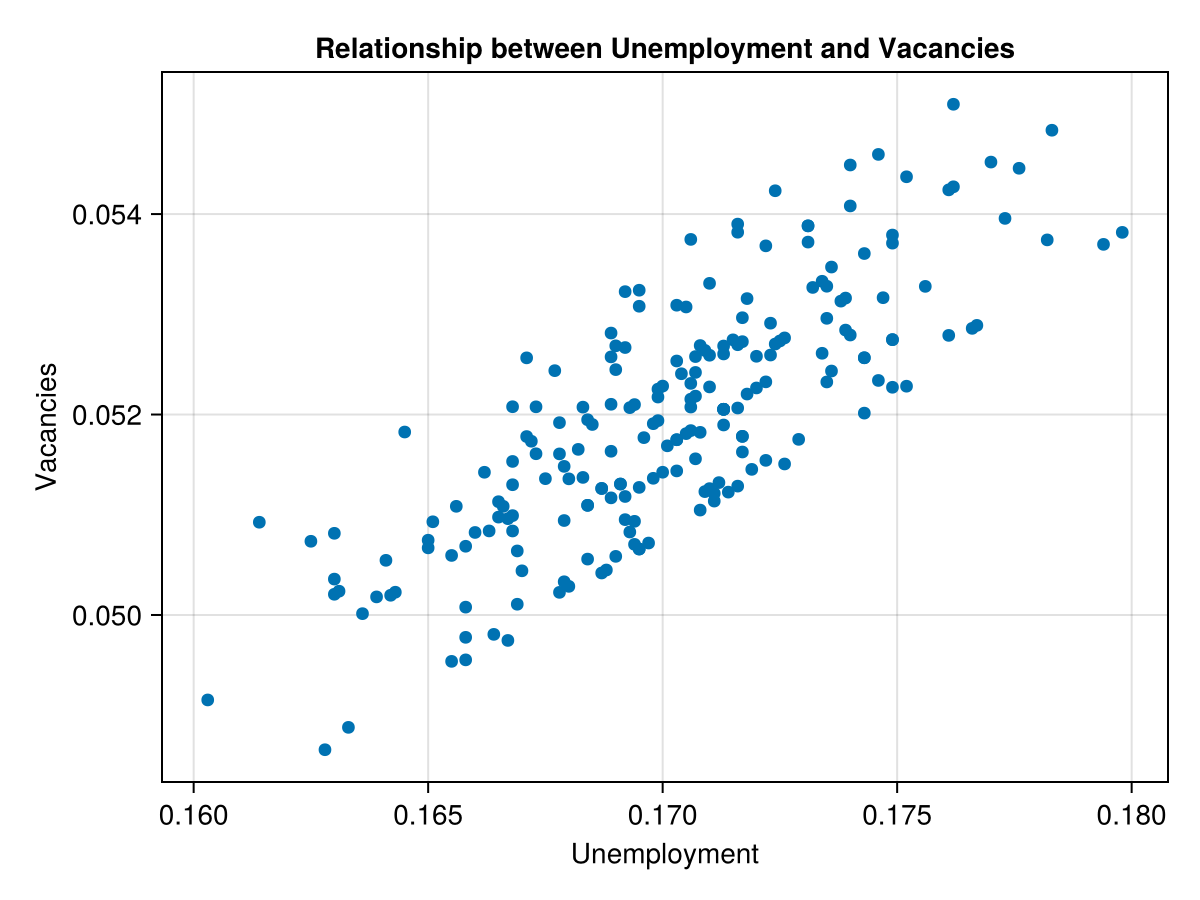

In [67]:
# Convert sim_u and sim_v to 1D arrays
β_sim_u_1d = vec(β_sim_u_last_212)
β_sim_v_1d = vec(β_sim_v_last_212)

# Create a scatter plot of sim_u_1d and sim_v_1d
fig = Figure()
ax = Axis(fig[1, 1], title = "Relationship between Unemployment and Vacancies", xlabel = "Unemployment", ylabel = "Vacancies")
scatter!(ax, β_sim_u_1d, β_sim_v_1d)
fig


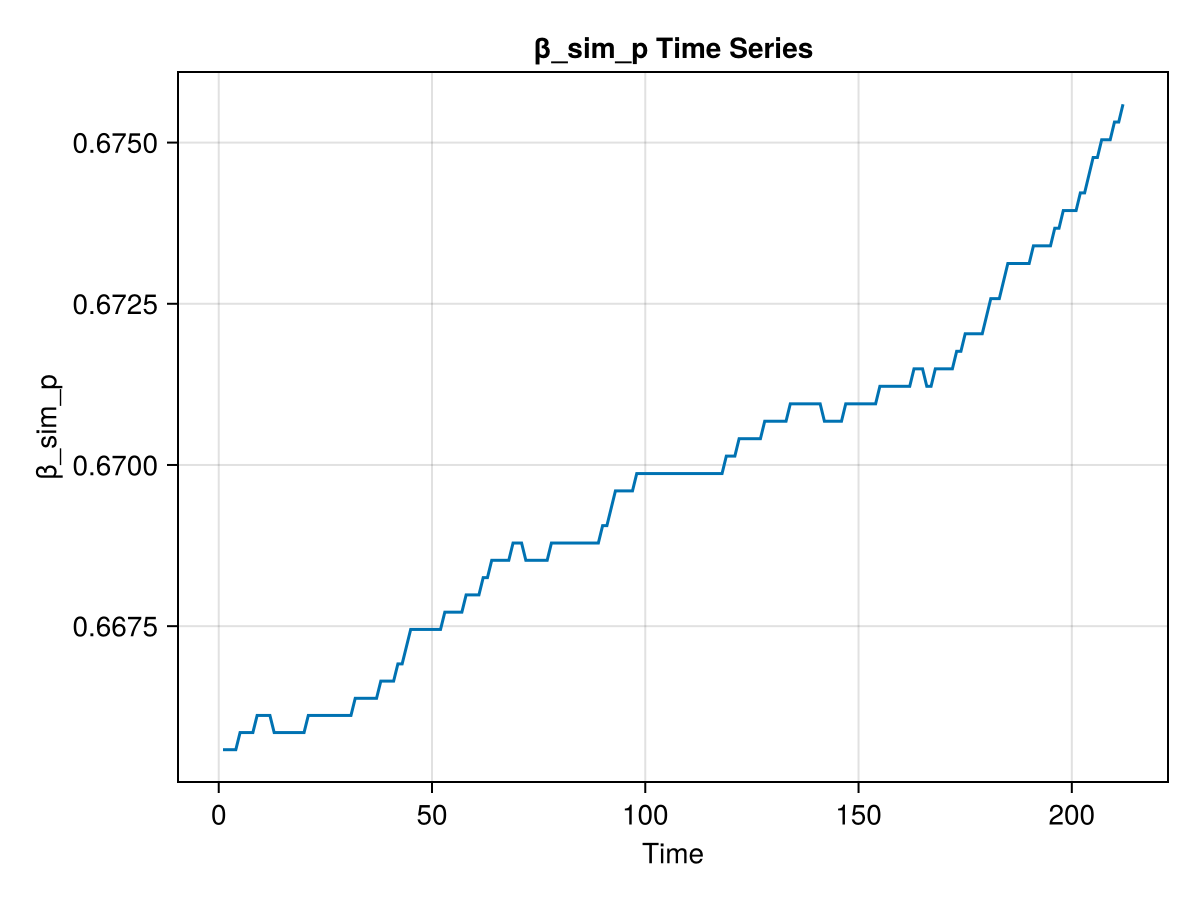

In [27]:
# Plot β_sim_p
fig_β_sim_p = Figure()
ax_β_sim_p = Axis(fig_β_sim_p[1, 1], title = "β_sim_p Time Series", xlabel = "Time", ylabel = "β_sim_p")
lines!(ax_β_sim_p, x, β_sim_p_last_212)
fig_β_sim_p

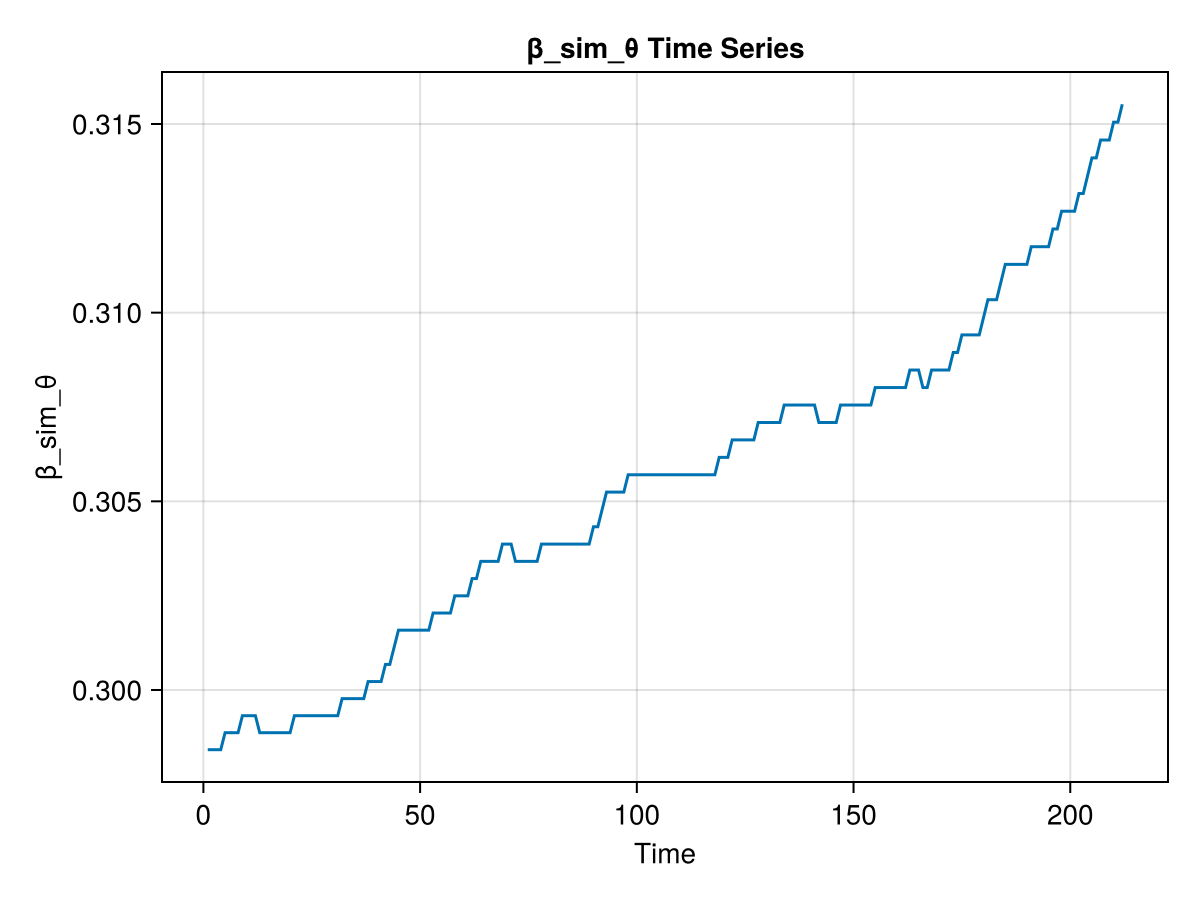

In [28]:
# Plot β_sim_θ
fig_β_sim_θ = Figure()
ax_β_sim_θ = Axis(fig_β_sim_θ[1, 1], title = "β_sim_θ Time Series", xlabel = "Time", ylabel = "β_sim_θ")
lines!(ax_β_sim_θ, x, β_sim_θ_last_212)
fig_β_sim_θ

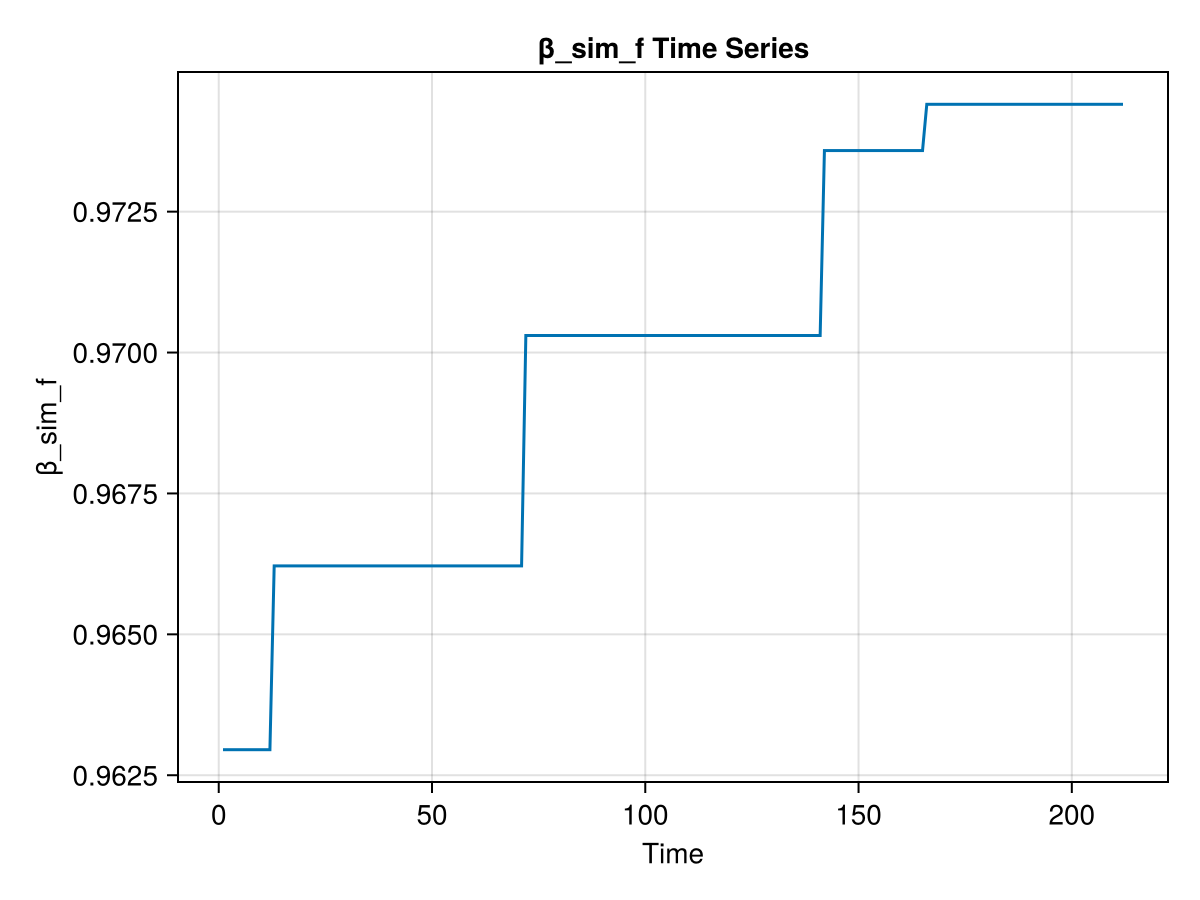

In [29]:
# Plot β_sim_f
fig_β_sim_f = Figure()
ax_β_sim_f = Axis(fig_β_sim_f[1, 1], title = "β_sim_f Time Series", xlabel = "Time", ylabel = "β_sim_f")
lines!(ax_β_sim_f, x, β_sim_f_last_212)
fig_β_sim_f

In [46]:
function z_grid(grid, params)
    (; n) = params
    return 0.9 .* grid
end

p_grid = productivity_grid(params)
leisure_grid = z_grid(p_grid, params)

2001-element Vector{Float64}:
 0.558654898232579
 0.5588536524913781
 0.5590526056038462
 0.5592517577689365
 0.5594511091858013
 0.5596506600537918
 0.5598504105724592
 0.5600503609415536
 0.5602505113610257
 0.5604508620310258
 ⋮
 1.816176056770627
 1.8176329611581832
 1.8190913231788208
 1.8205511442909044
 1.8220124259542534
 1.8234751696301503
 1.8249393767813384
 1.826405048872026
 1.8278721873678845

In [50]:
function optim_theta_z_grid(grid, params)
    (; β, r, λ, z, p_star, s_star, c, σ, γ, n, lb, ub, μ, me, max_iter) = params
    Δ = ub / n
    exp_grid, transition_matrix = generate_income_process(params)
    prod_grid = productivity_grid(params)
    leisure_grid = z_grid(prod_grid, params)
    iter = 0
    error = Inf
    new_grid = zeros(n)
    while iter < max_iter && error > 0.01
        iter += 1
        match_grid = matching_function(grid, params)
        for i in 1:n
            if i == 1
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-leisure_grid[i])) / c ) - β*theta[1] + λ*((transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            elseif i == n
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-leisure_grid[i])) / c ) - β*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1])), [grid[i]])
                new_grid[i] = result.zero[1]
            else
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-leisure_grid[i])) / c ) - β*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1]) + (transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            end
        end
        error = norm(new_grid - grid)
        grid = copy(new_grid)
        if iter % 1 == 0
            println("Iteration: $iter, Error: $error")
        end
    end
    find_probs = matching_function(grid, params).*grid
    find_probs = find_probs ./ maximum(find_probs)
    return grid, find_probs
end


θ_grid = theta_grid(params)
probs_find = optim_theta_z_grid(θ_grid, params)[2]

Iteration: 1, Error: 76.76808257762374
Iteration: 2, Error: 6.8545539371184265
Iteration: 3, Error: 1.0185907909694807
Iteration: 4, Error: 0.1309266326252595
Iteration: 5, Error: 0.017279910858295867
Iteration: 6, Error: 0.002311688621845582


2001-element Vector{Float64}:
 0.7075115587882572
 0.7075863339300561
 0.7076611401222699
 0.7077359278940621
 0.7078107929477656
 0.7078856577514553
 0.7079605421775689
 0.7080355244973197
 0.7081104097021018
 0.7081855125247576
 ⋮
 0.9981421047691539
 0.9983718072312314
 0.9986064557889213
 0.998838699022082
 0.9990701317045007
 0.999302643024196
 0.9995364058586029
 0.9997695717589064
 1.0

In [59]:
function simulation_z(params)
    (; agents, periods, n) = params
    
    p_grid = productivity_grid(params)
    s_grid = separation_grid(params)
    leisure_grid = z_grid(p_grid, params)
    p_init = p_grid[100]
    
    agg_prod, agg_transitions = generate_poisson_matrix(params)
    income_process, transitions = generate_income_process(params)
    
    index = findfirst(isequal(p_init), p_grid)
    
    initial_θ = θ_grid[index]
    
    employment_sim = zeros(agents , periods) 
    employment_sim[:,1] .= u_init .== 0.0
    
    sim_p = zeros(1, periods)
    sim_p[:,1] .= p_init
    
    sim_θ = zeros(1, periods)
    sim_θ[:,1] .= initial_θ
    
    sim_f = zeros(1, periods) # θ*q(θ)
    sim_f[:,1] .= sim_θ[:,1] .* matching_function(sim_θ[:,1], params)
    
    sim_u = zeros(1, periods)
    fraction = mean(u_init .== 1.0)
    sim_u[:,1] .= fraction
    
    sim_v = zeros(1, periods)
    sim_v[:,1] .= sim_u[:,1] .* sim_θ[:,1] 
    
    thetas, probs_find = optim_theta_z_grid(θ_grid, params)
    match_matrix = generate_matching_matrix(params)
    sep_matrix = generate_sep_matrix(params)
    
    for i in 1:agents
        for j in 1:periods
            index = findfirst(isequal(sim_p[1,j]), p_grid)
            if agg_prod[1,j] == 1.0
                if agg_transitions[1,j] <= transitions[index,index-1]
                    if index == 1
                        sim_p[1,j] = p_grid[index]
                        sim_p[1,j+1] = p_grid[index]
                        sim_θ[1,j] = thetas[index]
                        sim_θ[1,j+1] = thetas[index]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params))
                        sim_f[1,j+1] = sim_f[1,j]                  
                    else
                        sim_p[1,j] = p_grid[index-1]
                        sim_θ[1,j] = thetas[index-1]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params))
                        sim_p[1,j+1] = p_grid[index-1]
                        sim_θ[1,j+1] = thetas[index-1]
                        sim_f[1,j+1] = sim_f[1,j]  
                    end
                elseif index < n
                    index2 = index + 1
                    sim_p[1,j+1] = p_grid[index2]
                    sim_θ[1,j+1] = thetas[index2]
                    sim_f[1,j+1] = sim_f[1,j]
                elseif index == n
                    sim_p[1,j+1] = p_grid[index]
                    sim_θ[1,j+1] = thetas[index]
                    sim_f[1,j+1] = sim_f[1,j]
                end
            elseif j < periods 
                sim_p[1,j+1] = sim_p[1,j]
                sim_θ[1,j+1] = sim_θ[1,j]
                sim_f[1,j+1] = sim_f[1,j]   
            end
            if employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 0.0 && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 1.0 && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if employment_sim[i,j] == 0.0 && match_matrix[i,j] <= probs_find[index] && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 0.0 && match_matrix[i,j] > probs_find[index] && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if i == 1 && j == 1213
                println("completed agent $i")
            end
            if i % 1000 == 0 && j == 1213
                println("completed agent $i")
            end
        end
    end
    for j in 1:periods
        sim_u[1,j] = 1 - mean(employment_sim[:,j])
        sim_v[1,j] = sim_u[1,j] .* sim_θ[1,j]
    end
    return sim_u, sim_v, sim_p, sim_θ, sim_f
end

z_sim_u, z_sim_v, z_sim_p, z_sim_θ, z_sim_f = simulation_z(params)

Iteration: 1, Error: 76.76808257762374
Iteration: 2, Error: 6.8545539371184265
Iteration: 3, Error: 1.0185907909694807
Iteration: 4, Error: 0.1309266326252595
Iteration: 5, Error: 0.017279910858295867
Iteration: 6, Error: 0.002311688621845582
completed agent 1
completed agent 1000
completed agent 2000
completed agent 3000
completed agent 4000
completed agent 5000
completed agent 6000
completed agent 7000
completed agent 8000
completed agent 9000
completed agent 10000


([1.0 0.28480000000000005 … 0.11680000000000001 0.1169], [0.24355000000000004 0.06936304000000003 … 0.012232420753833588 0.01224836461925758], [0.6436979759787662 0.6436979759787662 … 0.6964651445536849 0.6967617579802342], [0.24355000000000004 0.24355000000000004 … 0.10472962974172592 0.10477642959159607], [0.9123972606684432 0.9123972606684432 … 0.7190289449708918 0.7190289449708918])

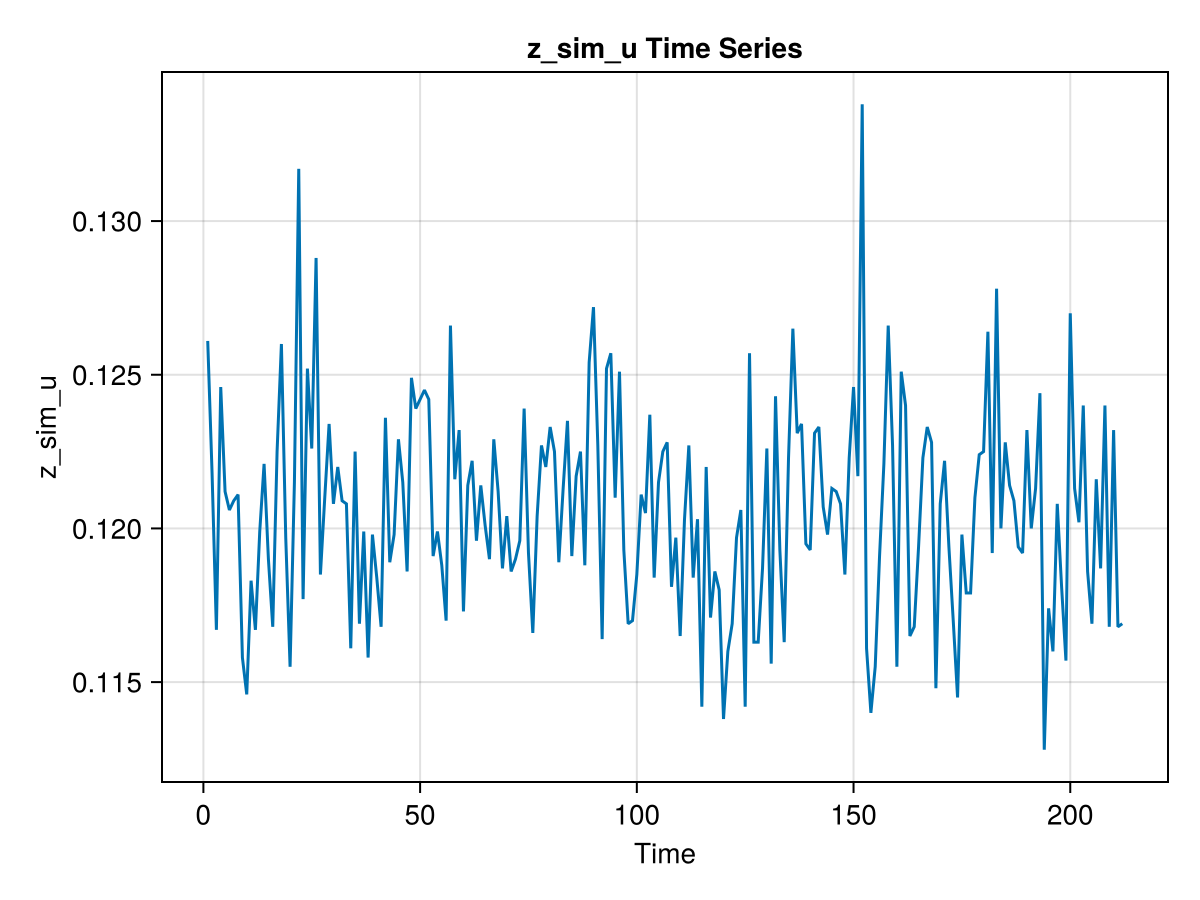

In [60]:
# Select the last 212 periods of each series
z_sim_u_last_212 = z_sim_u[end-211:end]
z_sim_v_last_212 = z_sim_v[end-211:end]
z_sim_p_last_212 = z_sim_p[end-211:end]
z_sim_θ_last_212 = z_sim_θ[end-211:end]
z_sim_f_last_212 = z_sim_f[end-211:end]

# Create a range of x-values
x = range(1, stop=212, length=length(β_sim_u_last_212))

# Plot β_sim_u
fig_z_sim_u = Figure()
ax_z_sim_u = Axis(fig_z_sim_u[1, 1], title = "z_sim_u Time Series", xlabel = "Time", ylabel = "z_sim_u")
lines!(ax_z_sim_u, x, z_sim_u_last_212)
fig_z_sim_u

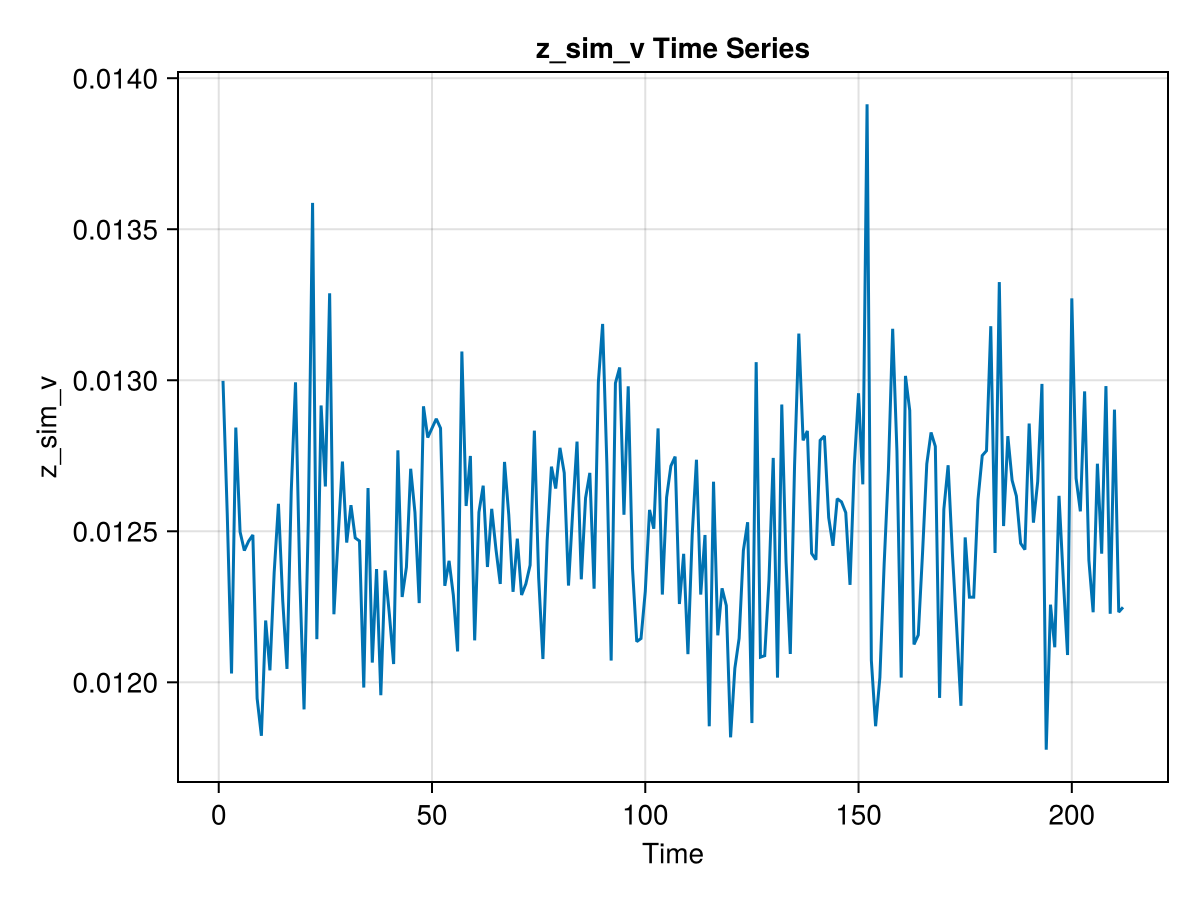

In [61]:
# Plot z_sim_v
fig_z_sim_v = Figure()
ax_z_sim_v = Axis(fig_z_sim_v[1, 1], title = "z_sim_v Time Series", xlabel = "Time", ylabel = "z_sim_v")
lines!(ax_z_sim_v, x, z_sim_v_last_212)
fig_z_sim_v

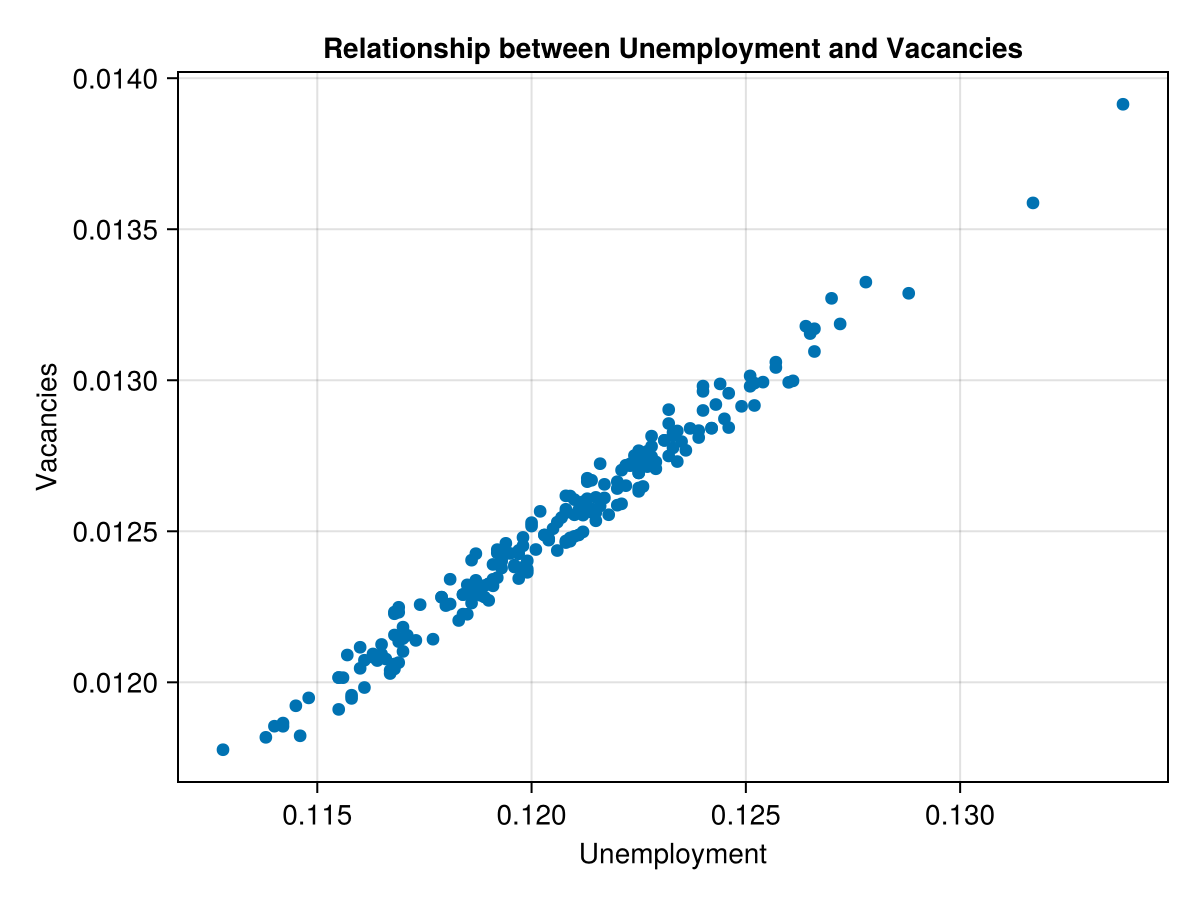

In [66]:
# Convert sim_u and sim_v to 1D arrays
z_sim_u_1d = vec(z_sim_u_last_212)
z_sim_v_1d = vec(z_sim_v_last_212)

# Create a scatter plot of sim_u_1d and sim_v_1d
fig = Figure()
ax = Axis(fig[1, 1], title = "Relationship between Unemployment and Vacancies", xlabel = "Unemployment", ylabel = "Vacancies")
scatter!(ax, z_sim_u_1d, z_sim_v_1d)
fig

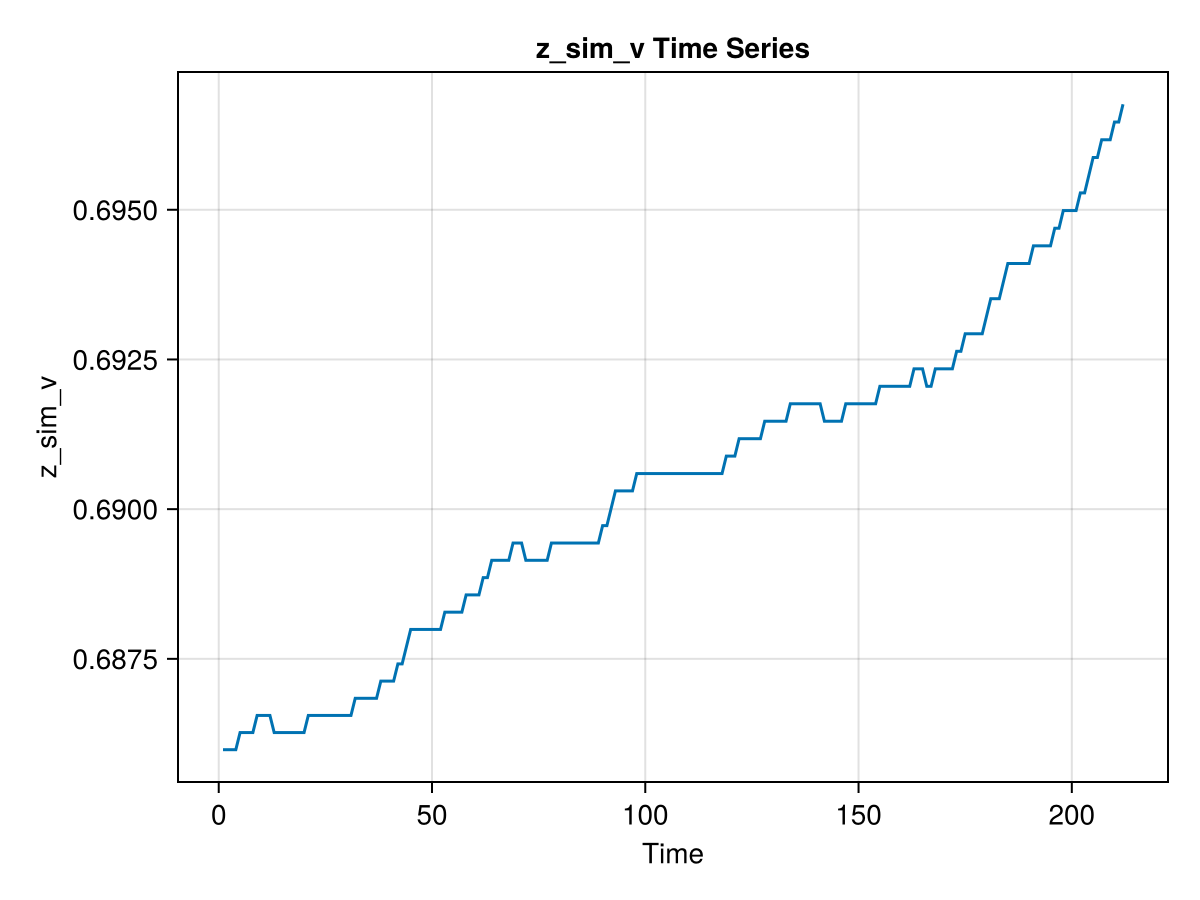

In [62]:
# Plot z_sim_p
fig_z_sim_p = Figure()
ax_z_sim_p = Axis(fig_z_sim_p[1, 1], title = "z_sim_v Time Series", xlabel = "Time", ylabel = "z_sim_v")
lines!(ax_z_sim_p, x, z_sim_p_last_212)
fig_z_sim_p

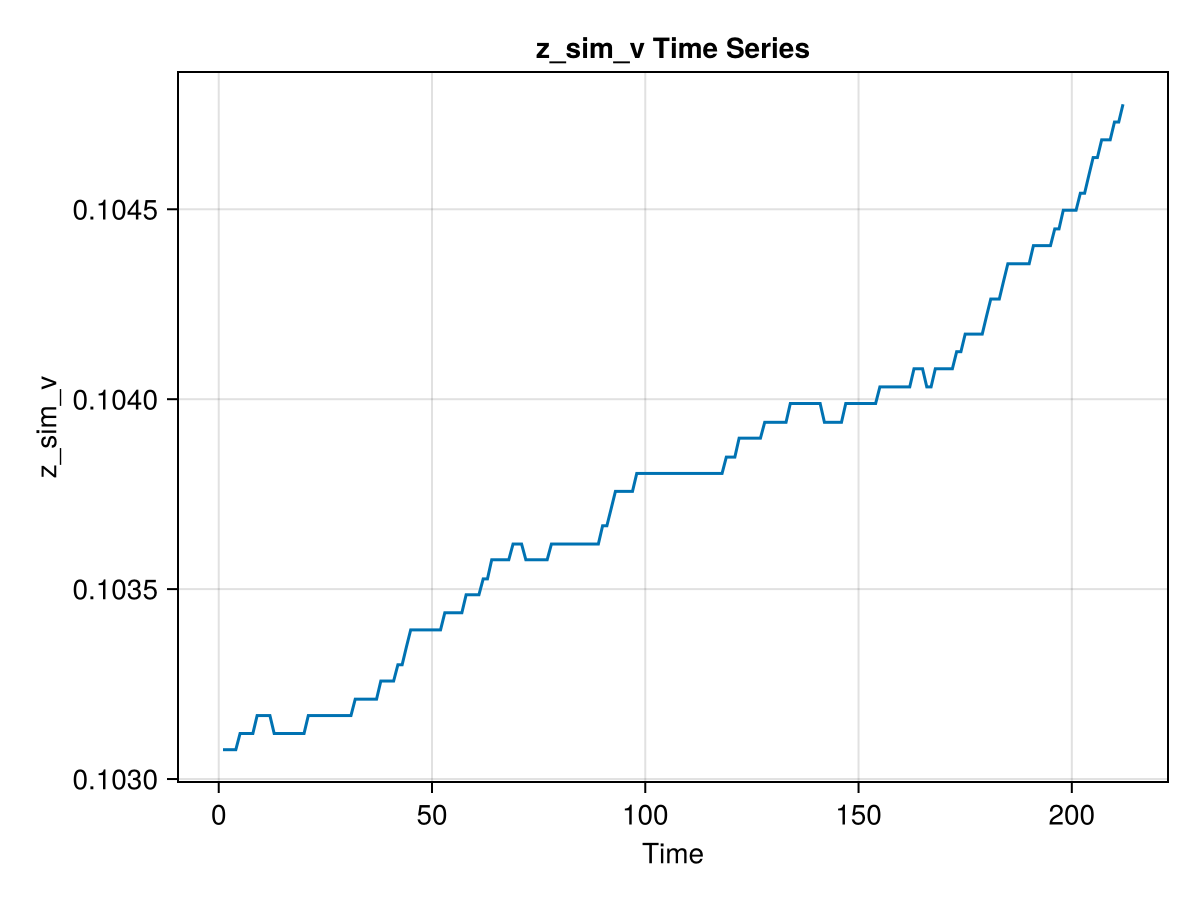

In [63]:
# Plot z_sim_θ
fig_z_sim_θ = Figure()
ax_z_sim_θ = Axis(fig_z_sim_θ[1, 1], title = "z_sim_v Time Series", xlabel = "Time", ylabel = "z_sim_v")
lines!(ax_z_sim_θ, x, z_sim_θ_last_212)
fig_z_sim_θ

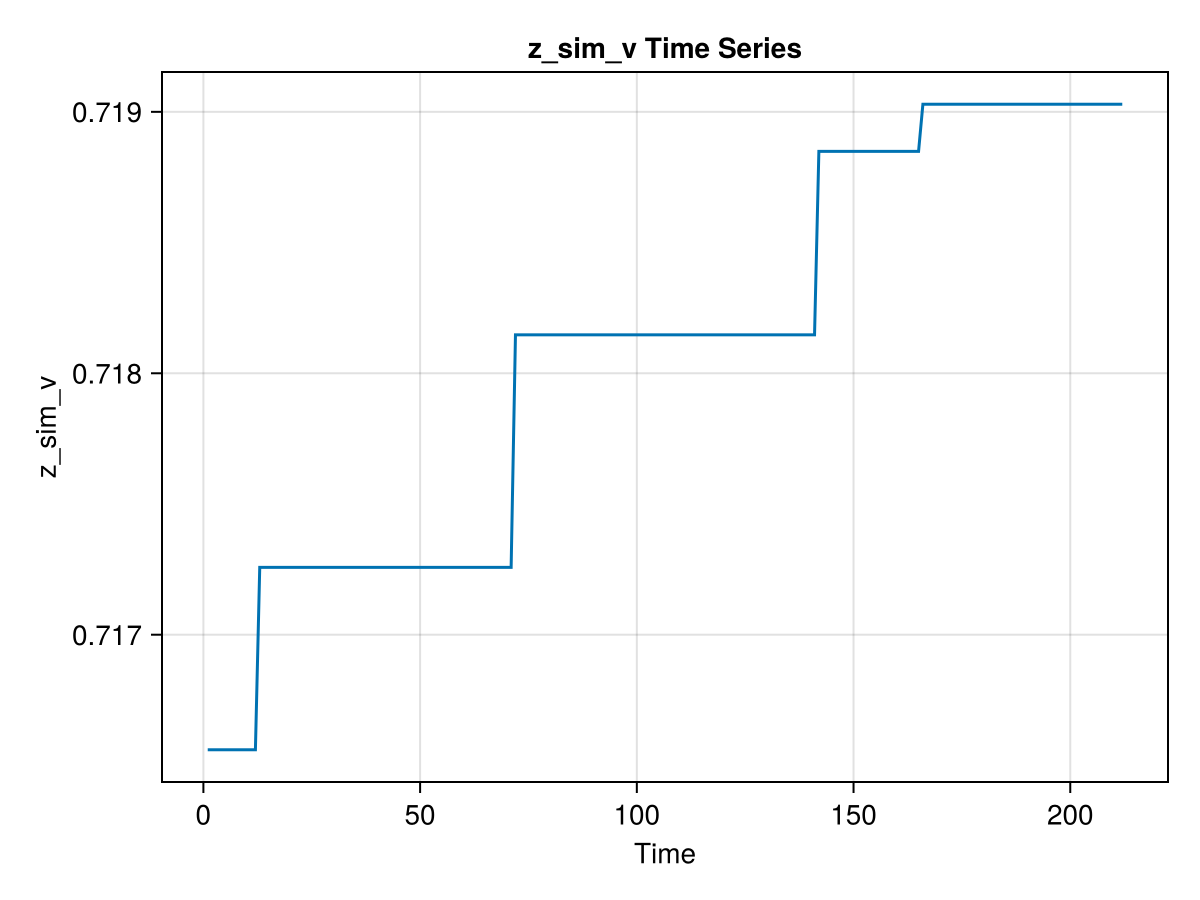

In [64]:
# Plot z_sim_f
fig_z_sim_f = Figure()
ax_z_sim_f = Axis(fig_z_sim_f[1, 1], title = "z_sim_v Time Series", xlabel = "Time", ylabel = "z_sim_v")
lines!(ax_z_sim_f, x, z_sim_f_last_212)
fig_z_sim_f